# Query by Donor Context #

## Overview ##

Query based on `ctx_donor` view

## Notebook Setup ##

* Configure database connect information and options
* Clear potentially interfering context (PostgreSQL doesn't let you replace a view definition with conflicting column names)
* Set styling for notebook

In [1]:
sqlconnect = "postgresql+psycopg2://crash@localhost/fecdb"

%load_ext sql
%config SqlMagic.autopandas=True
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
%sql $sqlconnect

'Connected: crash@fecdb'

In [2]:
%%html
<style>
  tr, th, td {
    text-align: left !important;
  }
</style>

## Query Election Cycle Giving Patterns ##

In [3]:
%sql drop materialized view if exists donor_ec_sum cascade
%sql drop materialized view if exists donor_ec_contrib cascade

 * postgresql+psycopg2://crash@localhost/fecdb
Done.
 * postgresql+psycopg2://crash@localhost/fecdb
Done.


""


In [4]:
%%sql
select count(*)
  from ctx_donor

 * postgresql+psycopg2://crash@localhost/fecdb
1 rows affected.


,count
0,50


This view rerepsents all of the contributions from the party/parties specified by `donor_ec_def`; note that multiple contributions on a given day (if/when it happens) are lumped together as `contrib_dt`, to make the overall reporting simpler.

In [5]:
%%sql
create materialized view donor_ec_contrib as
select ic.elect_cycle                                           as elect_cycle,
       ic.transaction_dt                                        as contrib_dt,
       sum(ic.transaction_amt)                                  as contrib_amt,
       count(*)                                                 as contribs,
       count(distinct i.name)                                   as donors,
       array_to_string(array_agg(distinct cmte.cmte_id), ', ')  as cmte_ids,
       array_to_string(array_agg(distinct cmte.cmte_nm), ' | ') as cmte_nms
  from ctx_donor dx
  join indiv i on i.donor_indiv_id = dx.id
  join indiv_contrib ic on ic.indiv_id = i.id
  left join cmte
       on cmte.cmte_id = ic.cmte_id
       and cmte.elect_cycle = ic.elect_cycle
 group by 1, 2

 * postgresql+psycopg2://crash@localhost/fecdb
1297 rows affected.


""


Aggregate the previous data by election cycle, showing the earliest and latest contributions for each cycle; note that `days_rel` represents days relative to the election date for the cycle (it goes without saying that negative is "before" the election date, and positive is "after").

In [6]:
%%sql
create materialized view donor_ec_sum as
select ec.key                                    as key,
       ec.election_day                           as election_day,
       count(*)                                  as contrib_dates,
       sum(bec.contrib_amt)                      as total_amt,
       round(sum(bec.contrib_amt) / count(*), 2) as avg_amt,
       min(bec.contrib_dt)                       as earliest,
       max(bec.contrib_dt)                       as latest,
       min(bec.contrib_dt) - ec.election_day     as erly_days_rel,
       max(bec.contrib_dt) - ec.election_day     as late_days_rel
  from donor_ec_contrib bec
  join election_cycle ec on ec.key = bec.elect_cycle
 group by 1, 2

 * postgresql+psycopg2://crash@localhost/fecdb
10 rows affected.


""


In [7]:
%%sql
select *
  from donor_ec_sum
 order by 1

 * postgresql+psycopg2://crash@localhost/fecdb
10 rows affected.


,key,election_day,contrib_dates,total_amt,avg_amt,earliest,latest,erly_days_rel,late_days_rel
0,2002,2002-11-05,4,3500.00,875.00,2002-04-19,2002-12-31,-200,56
1,2004,2004-11-02,8,31000.00,3875.00,2003-03-13,2004-10-19,-600,-14
2,2006,2006-11-07,12,14200.00,1183.33,2005-04-13,2006-11-03,-573,-4
3,2008,2008-11-04,11,13100.00,1190.91,2007-02-08,2008-09-30,-635,-35
4,2010,2010-11-02,13,12250.00,942.31,2009-02-28,2010-12-07,-612,35
5,2012,2012-11-06,18,21000.00,1166.67,2011-06-30,2012-11-06,-495,0
6,2014,2014-11-04,167,635002.00,3802.41,2013-01-05,2014-12-30,-668,56
7,2016,2016-11-08,334,1493514.00,4471.60,2015-01-11,2016-12-31,-667,53
8,2018,2018-11-06,588,3892299.00,6619.56,2017-01-05,2018-12-31,-670,55
9,2020,2020-11-03,142,547664.00,3856.79,2019-01-03,2019-07-31,-670,-461


For each of the contributions in `donor_ec_contrib`, we now query for the following:

* `cycle_pct`: percentage of the total for the cycle
* `cumul_cycle_amt`: cumulative amount for the cycle
* `cumul_cycle_pct`: cumulative percentage for the cycle
* `days_rel`: days before/after election date

We save the results into a local DataFrame for graphical visualization below.

In [8]:
%%sql result <<
select bec.elect_cycle,
       bec.contrib_dt,
       bec.contrib_amt                   as total_amt,
       round(bec.contrib_amt / bes.total_amt * 100.0, 1)
                                         as cycle_pct,
       cumul.total_amt                   as cumul_cycle_amt,
       round(cumul.total_amt / bes.total_amt * 100.0, 1)
                                         as cumul_cycle_pct,
       bec.contrib_dt - bes.election_day as days_rel
  from donor_ec_contrib bec
  join donor_ec_sum bes on bes.key = bec.elect_cycle
  left join lateral
       (select count(*)                as contribs,
               nullif(count(*) - 1, 0) as intervals,
               sum(bec2.contrib_amt)   as total_amt,
               max(bec2.contrib_dt) - min(bec2.contrib_dt)
                                       as elapsed_days
          from donor_ec_contrib bec2
         where bec2.elect_cycle = bec.elect_cycle
           and bec2.contrib_dt <= bec.contrib_dt
       ) as cumul on true
 order by 1, 2

 * postgresql+psycopg2://crash@localhost/fecdb
1297 rows affected.
Returning data to local variable result


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Plot cumulative amount given relative to election day (each color represents a different election cycle)

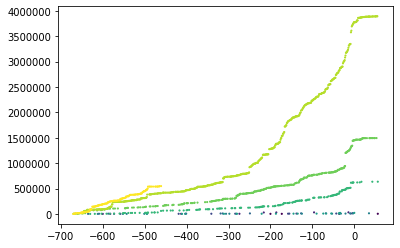

In [10]:
x = result['days_rel']
y = result['cumul_cycle_amt']
z = result['elect_cycle']

plt.scatter(x, y, marker='.', c=z, s=5)

Plot cumulative percentage (for the cycle) given relative to election day (again, each color represents a different election cycle)

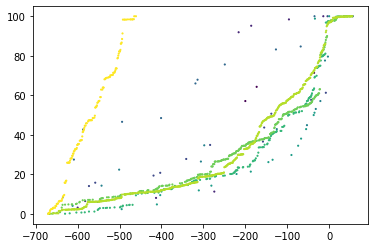

In [11]:
x = result['days_rel']
y = result['cumul_cycle_pct']
z = result['elect_cycle']

plt.scatter(x, y, marker='.', c=z, s=5)

Plot individual contributions (as a percentage for the cycle) relative to election day (again, each color represents a different election cycle); it is interesting to see when in the cycle significant contributions (on the order of a few percentage points or more--in some cases, much more!) have been given.

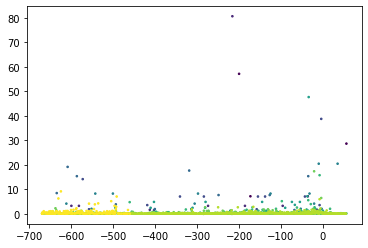

In [12]:
x = result['days_rel']
y = result['cycle_pct']
z = result['elect_cycle']

plt.scatter(x, y, marker='.', c=z, s=10)